## Tutorial VANs Amplitude Channel Discrimination: Optimal input

##### Loading the library

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

from utilities.circuit_basics import Basic
from utilities.idinserter import IdInserter
from utilities.qmodels import *
from utilities.variational import Minimizer
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder
from utilities.evaluator import Evaluator


In [2]:
basic = Basic(n_qubits=2, env_mode=1) #this is the module where basic functions are defined (and the rest of the modules inherits this classs)
inserter = IdInserter(n_qubits=basic.n_qubits) # we use this to insert gates in the circuit
minimizer = Minimizer(n_qubits=basic.n_qubits, epochs=10**3, env_mode = basic.env_mode) # we use this to minimize cost functions  (e.g. error probabilities)
simplifier = Simplifier(n_qubits=basic.n_qubits) #we use this to (if possible) reduce the circuit to an equivalent one whose depth is smaller
killer = UnitaryMurder(minimizer=minimizer) #we use this to delete gates that do not decrease the error probability very much

In [4]:
eta0 = 0.01
eta1 = 1.  

arguments={"problem_name":"QADC", "params":[eta0,eta1], "n_qubits":2, "env_mode":1}
evaluator = Evaluator(args = arguments) 

In [11]:
circuit=[]
### ENCODER BLOCK
circuit = [basic.give_gate_template(k, block_id=0, trainable=True) for k in basic.u2(0,1)] ## begin from z rotation (nothing)
## CHANNEL BLOCK ##
circuit += basic.give_channel_circuit_db([0,basic.env_mode], eta=eta0, block_id=1)  ###arbitrary choose one parameter
## DECODER BLOCK ##
#Nothing here!
circuit, symbols, circuit_db = basic.give_circuit(circuit)
circuit #let's print the circuit's object (CIRQ)

(0, 0): ───Rz(th_0)───Rx(th_1)───Rz(th_2)───@───Rz(th_6)───X──────────────@───Rz(th_9)────Rx(th_10)───Rz(th_11)───H───X────────────────X───H────────────────X───
                                            │              │              │                                           │                │                    │
(0, 1): ───Rz(th_3)───Rx(th_4)───Rz(th_5)───X───Ry(th_7)───@───Ry(th_8)───X───Rz(th_12)───Rx(th_13)───Rz(th_14)───H───@───Ry(0.006π)───@───H───Ry(0.006π)───@───

Define now an initial circuit to depart from. For this, CREATE INITIAL CIRCUIT CONSISTING ON ENCODER (block_id=0) CHANNEL (block_id=1) DECODER (block_id=2).

Note we will create a "batch" of circuits, each having a different channel, to compute the error probability (this is done later).


(0, 0): ───Rz(th_0)───H───X────────────────X───H────────────────X───
                          │                │                    │
(0, 1): ───H──────────────@───Ry(0.006π)───@───H───Ry(0.006π)───@───

In [6]:
batch = basic.prepare_channel_discrimination_circuits(circuit_db, other_eta=eta1) # here you see the remaining channel.

evaluator = Evaluator(args = arguments) 
start = datetime.now()

##### TRAIN ONCE #####
error_prob, symbol_to_value, training_evolution = minimizer.channel_discrimination(batch)
circuit_db = basic.update_circuit_db_param_values(circuit_db, symbol_to_value)    ## update database param_values
evaluator.add_step(circuit_db, error_prob, relevant=True)
print(evaluator.displaying["information"])

for it_vans in range(10):
    info = "Iteration number {}\nTime from start {}\nLowest Perr found {}\n\n".format(it_vans, str(datetime.now()-start), np.round(evaluator.lowest_energy,3) )
    print(info)
    
    evaluator.displaying["information"] += info
    ### ADD IDENTITIES ALL OVER THE CIRCUIT ###
    mutated_circuit_db = inserter.place_identities(circuit_db)
    
    ### SIMPLIFY CIRCUIT ####
    simplified_circuit_db = simplifier.simplify_blocks(mutated_circuit_db)
    
    ### TRAIN (MUTATED+SIMPLIFIED) CIRCUIT
    batch_simplified = basic.prepare_channel_discrimination_circuits(simplified_circuit_db)
    perr, symbol_to_value, training_evolution = minimizer.channel_discrimination(batch_simplified)
    simplified_circuit_db = basic.update_circuit_db_param_values(simplified_circuit_db, symbol_to_value)
    accept_mutation = evaluator.accept_energy(perr)
    
    if accept_mutation == True:
        ## Kill unnecessary gates + simplification rules if mutation is accepted
        lmax = len(circuit_db["trainable"] == True)
        reduced = True
        cnt=0
        while reduced and cnt<lmax:
            # KILL single-qubit gates 
            killed_circuit_db, perr, reduced, unitaries_killed = killer.unitary_slaughter(simplified_circuit_db)
            simplified_circuit_db = simplifier.simplify_blocks(killed_circuit_db)
            cnt+=1
    circuit_db = simplified_circuit_db
    ### save results of iteration ###w
    evaluator.add_step(circuit_db, perr, relevant=accept_mutation)


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

 Hola, I'm VANS, and current local time is 2021-11-04 11:42:25.948918 

Iteration number 0
Time from start 0:00:02.202398
Lowest Perr found 0.5


Iteration number 1
Time from start 0:00:05.608116
Lowest Perr found 0.18700000643730164


Iteration number 2
Time from start 0:00:09.499922
Lowest Perr found 0.14900000393390656


Iteration number 3
Time from start 0:00:11.463260
Lowest Perr found 0.14900000393390656


Iteration number 4
Time from start 0:00:12.826765
Lowest Perr found 0.14900000393390656


Iteration number 5
Time from start 0:00:14.127509
Lowest Perr found 0.14900000393390656


Iteration number 6
Time from start 0:00:16.205018
Lowest Perr found 0.14900000393390656


Iteration number 7
Time from start 0:00:18.584927
Lowest Perr found 0.14900000393390656


Iteration number 8
Time from start 0:00:20.890230
Lowest Perr found 0.14900000393390656


Iteration numbe

In [26]:
evaluator.etas = [0.01,1]

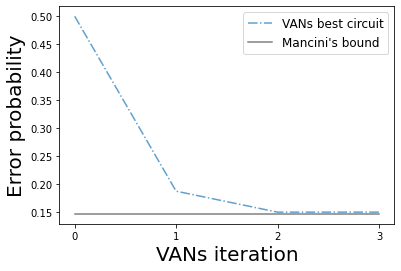

In [28]:
evaluator.show_evolution()

In [30]:
evaluator.give_circuit_from_db(circuit_db)[0]

(0, 0): ────────────────X───Rz(0.4π)──────Rx(0.703π)───────────────X───Rz(1.15π)──────────────X───Rx(1.82π)───Rz(-0.58π)───X───Rx(1.87π)─────Rz(-1.23π)───X───Rx(-0.516π)───Rz(0.82π)───Rx(0.205π)───Rz(-0.3π)───H───X────────────────X───H────────────────X───
                        │                                          │                          │                            │                              │                                                          │                │                    │
(0, 1): ───Rx(0.523π)───@───Rz(-0.954π)───Rx(-1.32π)───Rz(1.34π)───@───Rx(1.66π)───Rz(1.3π)───@────────────────────────────@───Rx(-0.368π)───Rz(0.796π)───@───Rx(-1.89π)────Rz(-1.7π)───H────────────────────────────@───Ry(0.006π)───@───H───Ry(0.006π)───@───

In [31]:
circuit_db

,ind,symbol,param_value,trainable,block_id,channel_param
0,5,th_0,1.643471,True,0,None
1,1,None,NaN,True,0,None
2,2,th_1,26.388678,True,0,None
3,3,th_2,9.569934,True,0,None
4,4,th_3,-10.358223,True,0,None
5,5,th_4,8.422107,True,0,None
6,3,th_5,4.194274,True,0,None
7,1,None,NaN,True,0,None
8,5,th_6,-32.483711,True,0,None
9,3,th_7,-8.493349,True,0,None
